# Analysis of Caffeine's Effects on Money Spending Trends

This notebook analyzes the relationship between caffeine consumption and money spending habits.

# Necessary Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Loading and Parsing Data

In [2]:
#Load and parse Hesap Hareketleri.xlsx
hesap_hareketleri = pd.ExcelFile('C:\\Users\\Arda Fero\\Desktop\\Hesap Hareketleri.xlsx')
df_hesap = hesap_hareketleri.parse('Hesap Hareketleri')

#Clean Hesap Hareketleri.xlsx
df_hesap_cleaned = df_hesap.iloc[3:, :2]
df_hesap_cleaned.columns = ['DateTime', 'Amount']
df_hesap_cleaned = df_hesap_cleaned.dropna().reset_index(drop=True)

#Remove rows where amount is invalid
df_hesap_cleaned = df_hesap_cleaned[df_hesap_cleaned['Amount'].str.contains(r'[0-9]', na=False)]

#Replace thousand separators and commas in amount
df_hesap_cleaned['Amount'] = df_hesap_cleaned['Amount'].str.replace('.', '', regex=False)
df_hesap_cleaned['Amount'] = df_hesap_cleaned['Amount'].str.replace(',', '.', regex=False)
df_hesap_cleaned['Amount'] = df_hesap_cleaned['Amount'].str.replace(' TL', '', regex=False)

#Convert amounts to numeric values
df_hesap_cleaned['Amount'] = pd.to_numeric(df_hesap_cleaned['Amount'], errors='coerce')

#Parse datetime
df_hesap_cleaned['Date'] = pd.to_datetime(df_hesap_cleaned['DateTime'].str[:10], errors='coerce')

#Filter out positive amounts (money received)
df_hesap_spent = df_hesap_cleaned[df_hesap_cleaned['Amount'] < 0]

#Remove the instance of 18k spending (outlier)
df_hesap_spent = df_hesap_spent[df_hesap_spent['Amount'] != -17399.00]

#Take absolute values of spending amounts
df_hesap_spent['Amount'] = df_hesap_spent['Amount'].abs()


#Group by date and calculate the total money spent per day
daily_spent_corrected = df_hesap_spent.groupby('Date')['Amount'].sum().reset_index()
daily_spent_corrected.columns = ['Date', 'Total Money Spent']
daily_spent_corrected['Date'] = pd.to_datetime(daily_spent_corrected['Date'])

print(daily_spent_corrected.to_string())


         Date  Total Money Spent
0  2024-09-28             710.93
1  2024-09-29             543.95
2  2024-10-01            1199.20
3  2024-10-02            1224.99
4  2024-10-06             371.45
5  2024-10-07            3484.67
6  2024-10-08             259.99
7  2024-10-09             325.00
8  2024-10-10              80.00
9  2024-10-11             618.00
10 2024-10-16              30.00
11 2024-10-17             199.99
12 2024-10-18             418.50
13 2024-10-19             340.00
14 2024-10-21             529.80
15 2024-10-29            2698.20
16 2024-10-31             158.00
17 2024-11-01             550.00
18 2024-11-02             600.00
19 2024-11-04             196.00
20 2024-11-05             490.00
21 2024-11-06             235.90
22 2024-11-07            1336.96
23 2024-11-08             179.99
24 2024-11-11             612.94
25 2024-11-13             200.00
26 2024-11-14             245.98
27 2024-11-15             952.00
28 2024-11-17             199.99
29 2024-11

In [3]:
#Load and parse Tasks.json
with open('C:\\Users\\Arda Fero\\Desktop\\Tasks.json', 'r', encoding='utf-8') as file:
    tasks_data = json.load(file)
task_items = tasks_data['items'][0]['items']
tasks_df = pd.DataFrame(task_items)
tasks_df['Date'] = pd.to_datetime(tasks_df['due']).dt.date
tasks_df['Caffeine (mg)'] = tasks_df['title'].astype(str).str.count('☕') * 120

#Adjust UTC time to local timezone (UTC+3 for Istanbul)
tasks_df['Due'] = pd.to_datetime(tasks_df['due'])
tasks_df['Hour'] = (tasks_df['Due'].dt.hour + 3) % 24
tasks_df['Date'] = pd.to_datetime(tasks_df['Date'])

#Group by date and calculate total caffeine consumed per day (each coffee emoji corresponds to ~120 milligrams of caffeine)
daily_caffeine = tasks_df.groupby('Date')['Caffeine (mg)'].sum().reset_index()
daily_caffeine.columns = ['Date', 'Total Caffeine Consumed (mg)']

print(tasks_df[['Date', 'title', 'Caffeine (mg)', 'Hour']].to_string())


          Date title  Caffeine (mg)  Hour
0   2024-12-18    ☕☕            240    20
1   2024-12-18    ☕☕            240    15
2   2024-12-18    ☕☕            240    11
3   2024-12-18    ☕☕            240     9
4   2024-12-17     ☕            120    20
5   2024-12-17    ☕☕            240    17
6   2024-12-17   ☕☕☕            360    13
7   2024-12-16    ☕☕            240    17
8   2024-12-16    ☕☕            240    14
9   2024-12-16    ☕☕            240    11
10  2024-12-16    ☕☕            240     9
11  2024-12-15    ☕☕            240    14
12  2024-12-15    ☕☕            240    13
13  2024-12-14   ☕☕☕            360     9
14  2024-12-13    ☕☕            240    22
15  2024-12-13    ☕☕            240    15
16  2024-12-13    ☕☕            240    14
17  2024-12-12     ☕            120    23
18  2024-12-12     ☕            120    19
19  2024-12-12     ☕            120    14
20  2024-12-12    ☕☕            240    12
21  2024-12-12   ☕☕☕            360    10
22  2024-12-11    ☕☕            24

In [4]:
#Merge the caffeine and spending data
data = pd.merge(daily_spent_corrected, daily_caffeine, on='Date', how='outer').fillna(0)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print(data.to_string())

            Total Money Spent  Total Caffeine Consumed (mg)
Date                                                       
2024-09-27               0.00                         240.0
2024-09-28             710.93                         240.0
2024-09-29             543.95                         240.0
2024-09-30               0.00                         240.0
2024-10-01            1199.20                         240.0
2024-10-02            1224.99                         240.0
2024-10-03               0.00                         600.0
2024-10-04               0.00                         120.0
2024-10-05               0.00                         720.0
2024-10-06             371.45                         120.0
2024-10-07            3484.67                         600.0
2024-10-08             259.99                         120.0
2024-10-09             325.00                         600.0
2024-10-10              80.00                         120.0
2024-10-11             618.00           

## Daily Money Spent (lineplot)

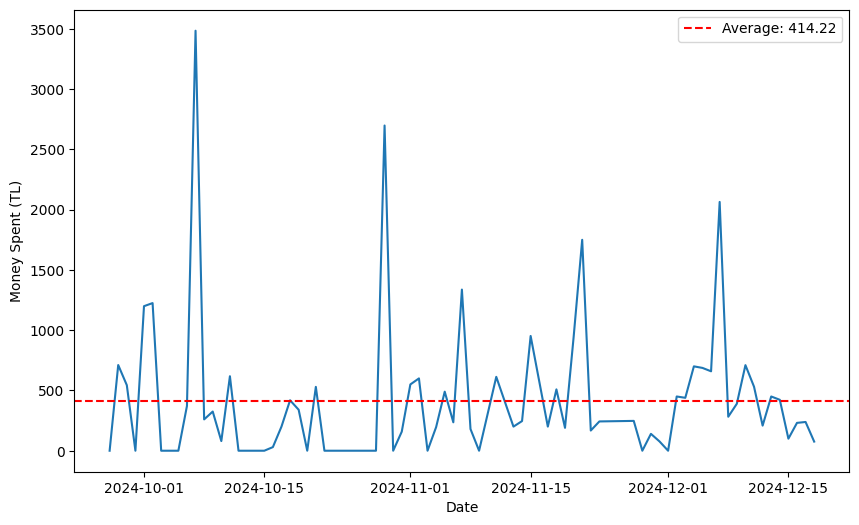

In [5]:
avg_money_spent = data['Total Money Spent'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, y='Total Money Spent', x=data.index)
plt.axhline(avg_money_spent, color='red', linestyle='--', label=f'Average: {avg_money_spent:.2f}')
plt.ylabel('Money Spent (TL)')
plt.legend()
plt.show()

## Daily Caffeine Consumption (lineplot)

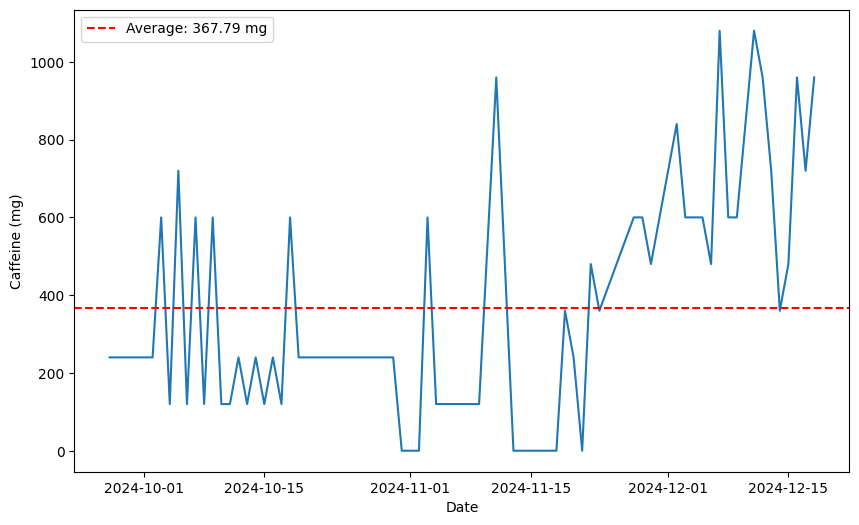

In [6]:
avg_caffeine = data['Total Caffeine Consumed (mg)'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, y='Total Caffeine Consumed (mg)', x=data.index)
plt.axhline(avg_caffeine, color='red', linestyle='--', label=f'Average: {avg_caffeine:.2f} mg')
plt.ylabel('Caffeine (mg)')
plt.legend()
plt.show()

## Total Caffeine Consumption by Time of Day (Bar chart)

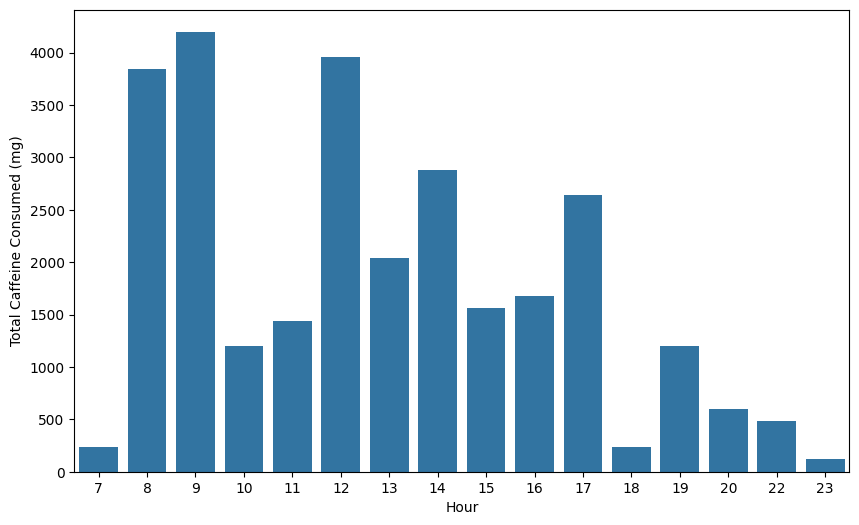

In [7]:
caffeine_by_hour = tasks_df.copy()
caffeine_by_hour['Hour'] = pd.to_datetime(tasks_df['due']).dt.hour + 3
hourly_caffeine = caffeine_by_hour.groupby('Hour')['Caffeine (mg)'].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_caffeine.index, y=hourly_caffeine.values)
plt.xlabel('Hour')
plt.ylabel('Total Caffeine Consumed (mg)')
plt.show()

## Average Caffeine Consumption by Time of Day (Bar chart)

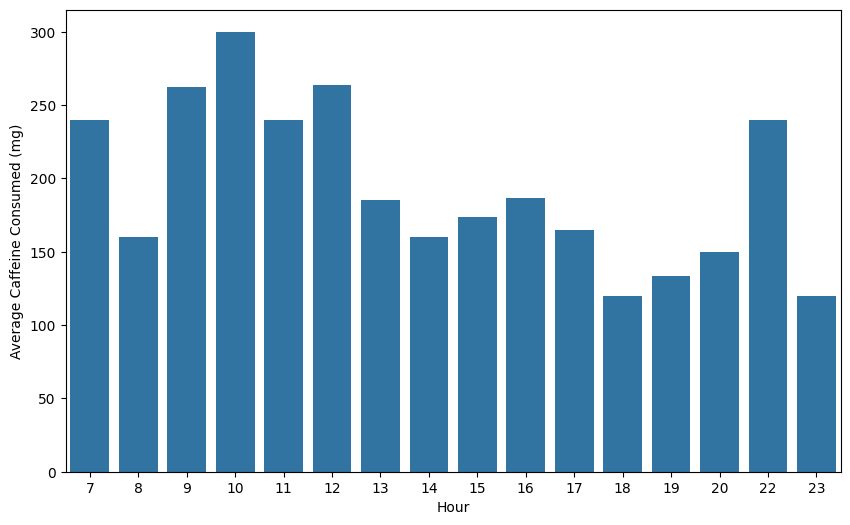

In [8]:
caffeine_by_hour = tasks_df.copy()
caffeine_by_hour['Hour'] = pd.to_datetime(tasks_df['due']).dt.hour + 3
hourly_caffeine = caffeine_by_hour.groupby('Hour')['Caffeine (mg)'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_caffeine.index, y=hourly_caffeine.values)
plt.xlabel('Hour')
plt.ylabel('Average Caffeine Consumed (mg)')
plt.show()

## Correlation Between Caffeine Intake and Money Spent (Scatterplot)

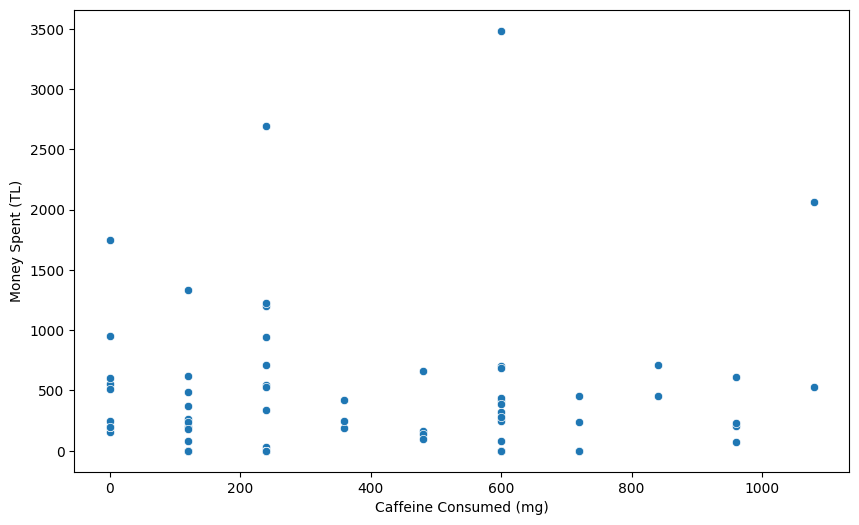

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Total Caffeine Consumed (mg)'], y=data['Total Money Spent'])
plt.xlabel('Caffeine Consumed (mg)')
plt.ylabel('Money Spent (TL)')
plt.show()

## Correlation Heatmap for Money Spent and Caffeine Consumed

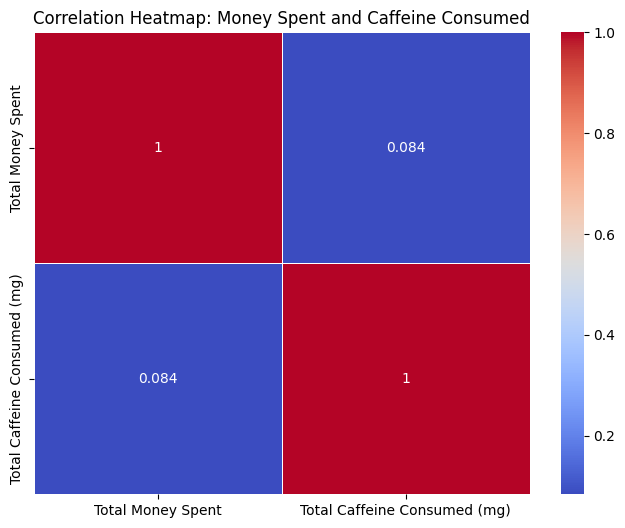

In [10]:
#Calculate the correlation matrix
correlation_matrix = data[['Total Money Spent', 'Total Caffeine Consumed (mg)']].corr()

#Create the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap: Money Spent and Caffeine Consumed')
plt.show()


## Linear Regression Model to Compare Actual vs Predicted Values

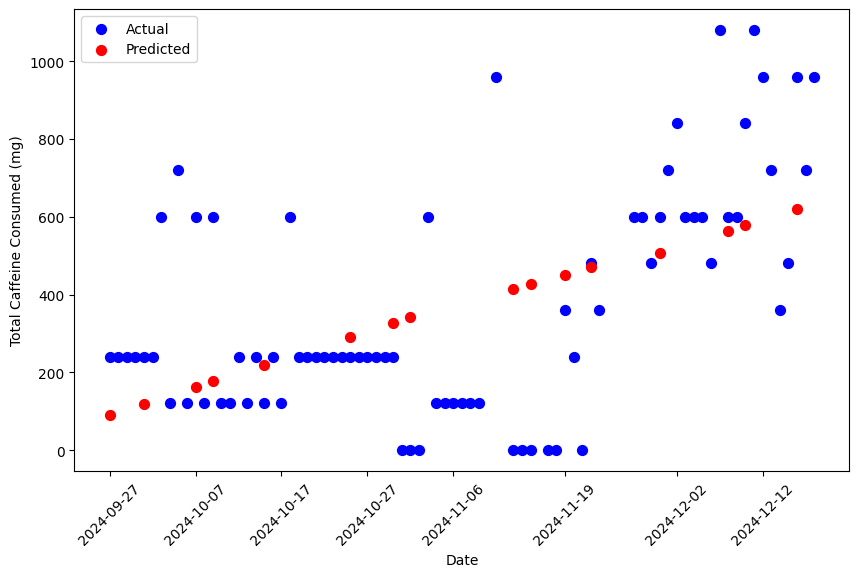

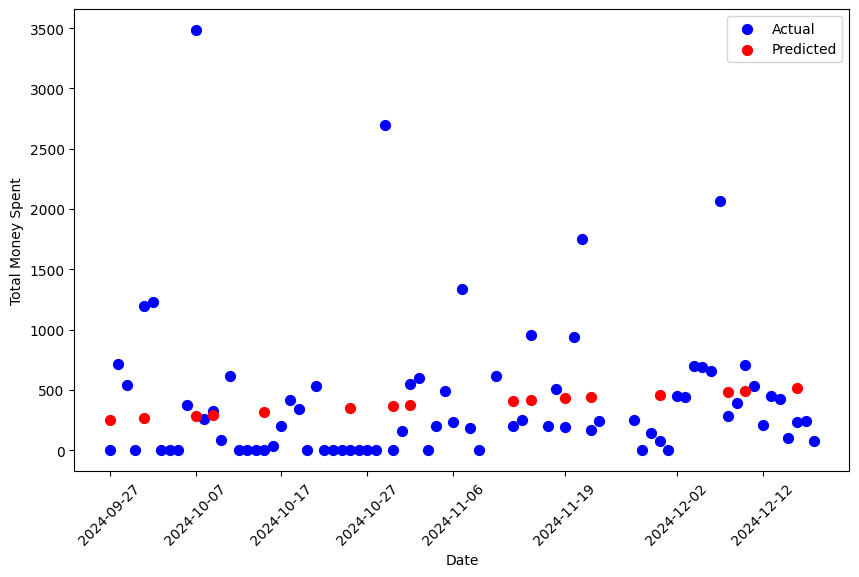

In [11]:
if 'day_of_year' not in data.columns:
    data['day_of_year'] = range(1, len(data) + 1)

#Function to train and plot actual vs predicted values
def train_and_plot_model(feature_col, target_col, title):
    X = data[[feature_col]].values
    y = data[target_col].values

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, data.index, test_size=0.2, random_state=42
    )

    #Create linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(data.index, data[target_col], label='Actual', color='blue', s=50)
    plt.scatter(idx_test, y_pred, color='red', label='Predicted', s=50)
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.xticks(data.index[::10], rotation=45)
    plt.show()

train_and_plot_model('day_of_year', 'Total Caffeine Consumed (mg)', 'Daily Caffeine Consumption')
train_and_plot_model('day_of_year', 'Total Money Spent', 'Daily Money Spent')
